# Thomas Brown - Applied Math Data Analyst Assessment:

# Q1:

You are provided with a data.csv file for the number of sales (in millions of units) and the price
for two products (product A and product B). You need to make a recommendation of the selling
price of both products given this historical data.

- Plot the data
- Fit the data
- Determine optimum selling price

# Importing Libraries:

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats


import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Importing Data:

In [2]:
# Importing the data and taking a first look:
df = pd.read_csv('data.csv')
display(df.head())
display(df.shape)
display(df.describe())

,Price Product A ($),Sales Product A (millions of unit),Price Product B ($),Sales Product B (millions of unit)
0,6.62,64.152047,6.75,54.512467
1,8.71,38.973806,12.67,0.000000
2,7.07,64.686109,9.91,31.309992
3,6.08,71.023195,5.42,66.603478
4,5.94,69.913545,12.82,0.000000


(900, 4)

,Price Product A ($),Sales Product A (millions of unit),Price Product B ($),Sales Product B (millions of unit)
count,700.000000,686.000000,900.000000,888.000000
mean,8.495000,39.316490,9.495000,29.928106
std,2.022169,25.794599,2.599519,24.761206
min,5.000000,0.000000,5.000000,0.000000
25%,6.747500,13.806711,7.247500,0.000000
50%,8.495000,44.779531,9.495000,32.001810
75%,10.242500,63.277062,11.742500,54.506361
max,11.990000,82.240023,13.990000,81.298512


# Data Cleaning:

In [3]:
df.isna().sum()
# Strange. . . let's look into this some more.

Price Product A ($)                   200
Sales Product A (millions of unit)    214
Price Product B ($)                     0
Sales Product B (millions of unit)     12
dtype: int64

In [4]:
df.tail(10)

,Price Product A ($),Sales Product A (millions of unit),Price Product B ($),Sales Product B (millions of unit)
890,NaN,NaN,10.95,5.862250
891,NaN,NaN,6.92,NaN
892,NaN,NaN,10.11,24.186946
893,NaN,NaN,8.57,47.740424
894,NaN,NaN,5.71,61.218970
895,NaN,NaN,12.12,0.000000
896,NaN,NaN,12.01,0.000000
897,NaN,NaN,13.80,0.000000
898,NaN,NaN,11.66,0.000000
899,NaN,NaN,8.20,47.593318


It looks like Product A simply has fewer records than Product B. For now, simply separating out the two products into two separate data frames will solve this issue. 

For the remaining 14 and 12 missing values, I'll likely drop those as there aren't any hints as to what the true value could be aside from the modeling we're already doing. 

Next, I'll separate out the products into their own dataframes (and rename the columns for convenience):

In [5]:
dfa = df.drop(columns = ['Price Product B ($)', 'Sales Product B (millions of unit)'], axis = 1)
dfb = df.drop(columns = ['Price Product A ($)', 'Sales Product A (millions of unit)'], axis = 1)

dfa.rename(columns = {'Price Product A ($)':'Price', 
                      'Sales Product A (millions of unit)':'Sales'}, 
                       inplace = True)
dfb.rename(columns = {'Price Product B ($)':'Price', 
                      'Sales Product B (millions of unit)':'Sales'}, 
                       inplace = True)

print('Product A:\n')
display(dfa.head())
print('Product B:\n')
display(dfb.head())

Product A:



,Price,Sales
0,6.62,64.152047
1,8.71,38.973806
2,7.07,64.686109
3,6.08,71.023195
4,5.94,69.913545


Product B:



,Price,Sales
0,6.75,54.512467
1,12.67,0.000000
2,9.91,31.309992
3,5.42,66.603478
4,12.82,0.000000


Next, I'll drop the remaining null values:

In [6]:
dfa.dropna(inplace = True)
dfb.dropna(inplace = True)

display(dfa.info())
display(dfb.info())

# Looks good so far

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 698
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   686 non-null    float64
 1   Sales   686 non-null    float64
dtypes: float64(2)
memory usage: 16.1 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   888 non-null    float64
 1   Sales   888 non-null    float64
dtypes: float64(2)
memory usage: 20.8 KB


None

In [7]:
dfa.Sales.value_counts()

0.000000     108
39.590308      1
51.264480      1
42.865945      1
33.681654      1
            ... 
71.410275      1
55.490233      1
50.900537      1
22.633995      1
35.361217      1
Name: Sales, Length: 579, dtype: int64

In [8]:
dfb.Sales.value_counts()

0.000000     246
0.346773       1
43.823413      1
28.148073      1
49.730089      1
            ... 
30.570532      1
59.165761      1
64.252986      1
61.920889      1
54.079376      1
Name: Sales, Length: 643, dtype: int64

Let's plot it out, but it's likely best to get rid of the records with 0 sales as this will skew the data.

In [9]:
dfa =dfa[dfa['Sales'] !=0]
dfb =dfb[dfb['Sales'] !=0]

# Exploratory Data Analysis:

Now, I'll pull up a couple scatterplots/lineplots to observe the data:

First, let's create a revenue column. This will help in the visualizations:

In [10]:
dfa['Revenue'] = dfa.Price * dfa.Sales
dfb['Revenue'] = dfb.Price * dfb.Sales

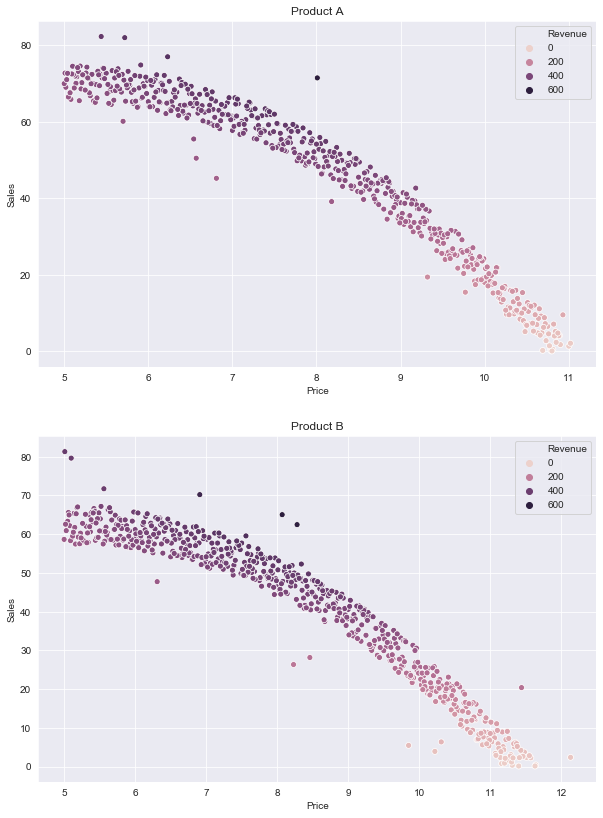

In [11]:
plt.figure(figsize=(10, 14))

ax1 = plt.subplot(2, 1, 1)
ax1 = sns.scatterplot(data = dfa, x= 'Price', y = 'Sales', 
                      hue = "Revenue", marker = 'o')
ax1.set_title('Product A')

ax2 = plt.subplot(2, 1, 2)
ax2 = sns.scatterplot(data = dfb, x= 'Price', y = 'Sales', 
                      hue = "Revenue", marker = 'o')
ax2.set_title('Product B');

Right off the bat, I can make a few observations:
1. As price increases for both products, units sold decreases. This is to be expected for most types of products.
2. While lower prices increase unites sold, revenue (price x sales) peaks around 7-8 dollars for both products. You can see this through the color of the plot (darker = higher revenue).

# Fitting the Data:

## X and y:

I'll get back to revenue later on when determining ideal price, but for now, the X variable will be price, and the y variable, i.e. the variable I'm modeling for will be sales.

In essence, the question I'm trying to answer is "What will sales be at a given price?"

In [12]:
X_a = dfa['Price']
X_b = dfb['Price']
y_a = dfa['Sales']
y_b = dfb['Sales']

## Train Test Split:

In [13]:
# Product A:
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y_a, 
                                                            test_size=0.2, 
                                                            random_state=42) # To make it repeatable
print('Product A Train/Test Split Sizes:', len(X_a_train), len(X_a_test), len(y_a_train), len(y_a_test))

# Product B:
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, 
                                                            test_size=0.2, 
                                                            random_state=42) # To make it repeatable
print('Product B Train/Test Split Sizes:', len(X_b_train), len(X_b_test), len(y_b_train), len(y_b_test))

Product A Train/Test Split Sizes: 462 116 462 116
Product B Train/Test Split Sizes: 513 129 513 129


## Baseline Models and Evaluation:

For the baseline model, I'll be using a simple linear model. As you can see in the visualization, a polynomial model will likely be much more accurate, but I'll be using that for the improved model. It's always important to get a baseline model down so you can be sure the more complex model actually improves accuracy!

### Product A:

In [14]:
baseline_model_a = sm.OLS(y_a_train, X_a_train).fit()
baseline_model_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.645
Model:                            OLS   Adj. R-squared (uncentered):              0.644
Method:                 Least Squares   F-statistic:                              838.5
Date:                Mon, 09 Nov 2020   Prob (F-statistic):                   8.41e-106
Time:                        14:57:35   Log-Likelihood:                         -2230.2
No. Observations:                 462   AIC:                                      4462.
Df Residuals:                     461   BIC:                                      4467.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Price          4.9794      0.172     28.956      0.000       4.641       5.317
==============================================================================
Omnibus:                      165.372   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.060
Skew:                          -0.355   Prob(JB):                     6.62e-08
Kurtosis:                       1.898   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

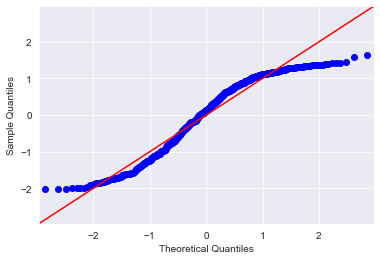

In [15]:
fig = sm.graphics.qqplot(baseline_model_a.resid, dist=stats.norm, line='45', fit=True)

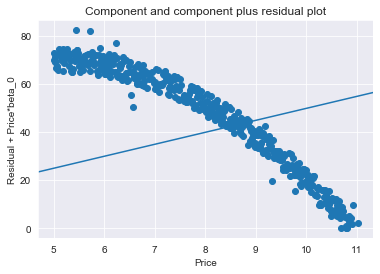

In [16]:
fig = sm.graphics.plot_ccpr(baseline_model_a, 'Price')

### Product B:

In [17]:
baseline_model_b = sm.OLS(y_b_train, X_b_train).fit()
baseline_model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.634
Method:                 Least Squares   F-statistic:                              889.5
Date:                Mon, 09 Nov 2020   Prob (F-statistic):                   4.93e-114
Time:                        14:57:36   Log-Likelihood:                         -2430.2
No. Observations:                 513   AIC:                                      4862.
Df Residuals:                     512   BIC:                                      4867.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Price          4.3097      0.145     29.824      0.000       4.026       4.594
==============================================================================
Omnibus:                      142.584   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.065
Skew:                          -0.472   Prob(JB):                     7.34e-10
Kurtosis:                       1.962   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

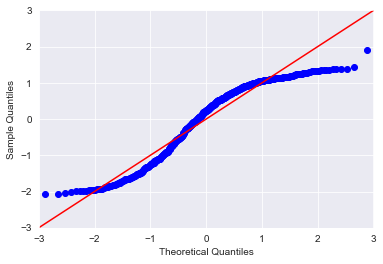

In [18]:
fig = sm.graphics.qqplot(baseline_model_b.resid, dist=stats.norm, line='45', fit=True)

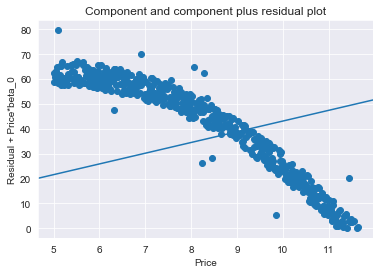

In [19]:
fig = sm.graphics.plot_ccpr(baseline_model_b, 'Price')

### Model Evaluation:

So far, I have an R2 of ~.64 for both models and QQ plots that show high variability in residuals. This signifies that I am missing something in the analysis, as the residuals should be hugging the red center line on the QQ plots much more closely.

You can also see that the curve is not fit at all. There's quite a bit of room for improvement here!

## Improved (Polynomial) Model:

### X and y:

First, I'll start by making this a polynomial model by adding price squared. This should allow the curve to fit much better.

In [20]:
dfa['Price2'] = dfa.Price ** 2
dfb['Price2'] = dfb.Price ** 2

X_a = dfa[['Price', 'Price2']]
X_b = dfb[['Price', 'Price2']]
y_a = dfa['Sales']
y_b = dfb['Sales']

In [21]:
# Product A:
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y_a, 
                                                            test_size=0.2, 
                                                            random_state=42) # To make it repeatable
print('Product A Train/Test Split Sizes:', len(X_a_train), len(X_a_test), len(y_a_train), len(y_a_test))

# Product B:
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, 
                                                            test_size=0.2, 
                                                            random_state=42) # To make it repeatable
print('Product B Train/Test Split Sizes:', len(X_b_train), len(X_b_test), len(y_b_train), len(y_b_test))

Product A Train/Test Split Sizes: 462 116 462 116
Product B Train/Test Split Sizes: 513 129 513 129


### Product A:

In [22]:
model_a = sm.OLS(y_a_train, X_a_train).fit()
model_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          4.934e+04
Date:                Mon, 09 Nov 2020   Prob (F-statistic):                        0.00
Time:                        14:57:37   Log-Likelihood:                         -1228.5
No. Observations:                 462   AIC:                                      2461.
Df Residuals:                     460   BIC:                                      2469.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Price         25.1229      0.110    228.606      0.000      24.907      25.339
Price2        -2.3129      0.012   -186.310      0.000      -2.337      -2.288
==============================================================================
Omnibus:                       15.687   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.119
Skew:                          -0.009   Prob(JB):                     2.37e-08
Kurtosis:                       4.351   Cond. No.                         50.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

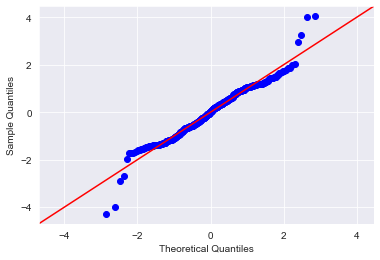

In [23]:
fig = sm.graphics.qqplot(model_a.resid, dist=stats.norm, line='45', fit=True)

There are a few outliers that are giving me trouble, but overall the residuals fit the center line quite well!

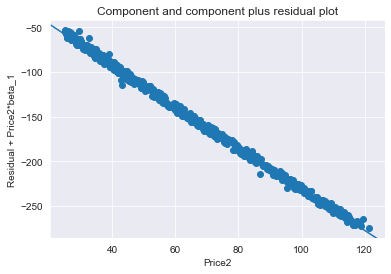

In [24]:
fig = sm.graphics.plot_ccpr(model_a, 'Price2')

### Product B:

In [25]:
model_b = sm.OLS(y_b_train, X_b_train).fit()
model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          3.522e+04
Date:                Mon, 09 Nov 2020   Prob (F-statistic):                        0.00
Time:                        14:57:38   Log-Likelihood:                         -1423.1
No. Observations:                 513   AIC:                                      2850.
Df Residuals:                     511   BIC:                                      2859.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Price         21.1343      0.107    196.620      0.000      20.923      21.346
Price2        -1.8592      0.012   -159.397      0.000      -1.882      -1.836
==============================================================================
Omnibus:                       85.160   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1186.133
Skew:                           0.025   Prob(JB):                    2.72e-258
Kurtosis:                      10.449   Cond. No.                         49.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

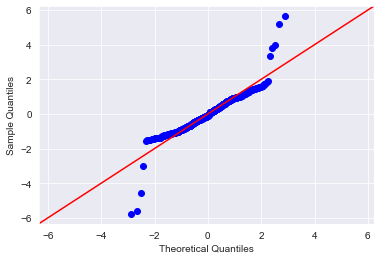

In [26]:
fig = sm.graphics.qqplot(model_b.resid, dist=stats.norm, line='45', fit=True)

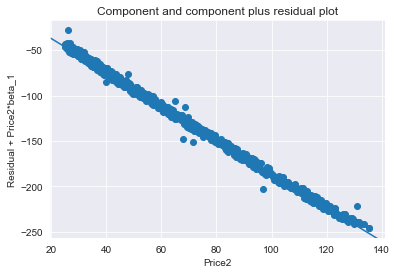

In [27]:
fig = sm.graphics.plot_ccpr(model_b, 'Price2')

### Model Evaluation:

These models fit much better than the baseline. Right off the bat, you can see that the R2 is much higher (~.95) and the QQ plots are much tighter around the center line. Lets move on to final predictions and see what the ideal price is for maximum revenue for each product.

# Conclusion:

In [28]:
# Setting a range of prices to predict sales based on:

data = {'Price': np.linspace(5, 11.5, 1000)}
dfxa = pd.DataFrame(data)
dfxb = pd.DataFrame(data)
dfxa['Price2'] = dfxa['Price'] ** 2
dfxb['Price2'] = dfxb['Price'] ** 2

X_new_a = dfxa[['Price', 'Price2']]
X_new_b = dfxb[['Price', 'Price2']]
# This will work for Product A and Product B

In [29]:
sales_pred_a =  model_a.predict(X_new_a) 
sales_pred_b = model_b.predict(X_new_b) 

In [30]:
dfxa['Sales_Prediction'] = sales_pred_a
dfxb['Sales_Prediction'] = sales_pred_b

dfxa['Revenue_Prediction'] = dfxa.Sales_Prediction * dfxa.Price
dfxb['Revenue_Prediction'] = dfxb.Sales_Prediction * dfxb.Price

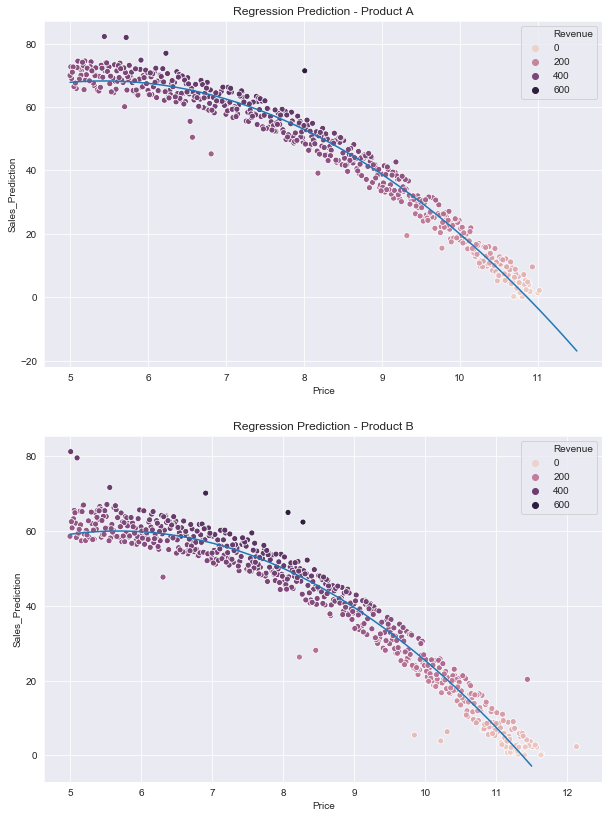

In [31]:
plt.figure(figsize=(10, 14))

# Product A:

ax1 = plt.subplot(2, 1, 1)
ax1 = sns.scatterplot(data = dfa, x= 'Price', y = 'Sales', 
                      hue = "Revenue", marker = 'o')

ax2 = plt.subplot(2, 1, 1)
ax2 = sns.lineplot(data = dfxa, x= 'Price', y = 'Sales_Prediction')

ax2.set_title('Regression Prediction - Product A');

# Product B:

ax3 = plt.subplot(2, 1, 2)
ax3 = sns.scatterplot(data = dfb, x= 'Price', y = 'Sales', 
                      hue = "Revenue", marker = 'o')

ax4 = plt.subplot(2, 1, 2)
ax4 = sns.lineplot(data = dfxb, x= 'Price', y = 'Sales_Prediction')

ax4.set_title('Regression Prediction - Product B');


## Setting the Ideal Price (Using Predicted Revenue):

When setting the ideal price, we shouldn't be focused on units sold as much as we should be focused on revenue. If I had the data on the original cost to produce the products, I would be even more focused on profit, but for now, revenue is a great stand in. Let's see which price maximizes revenue:

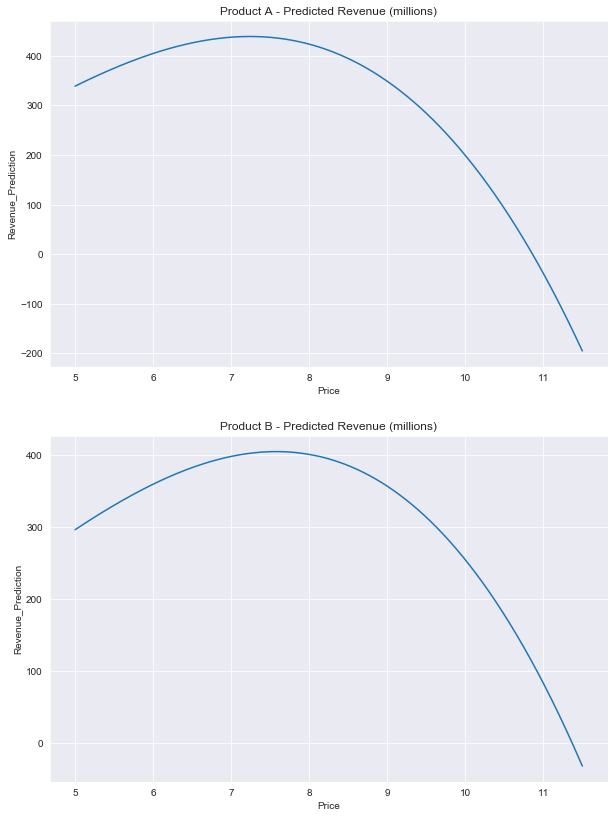

In [32]:
plt.figure(figsize=(10, 14))


ax1 = plt.subplot(2, 1, 1)
ax1 = sns.lineplot(data = dfxa, x= 'Price', y = 'Revenue_Prediction')
ax1.set_title('Product A - Predicted Revenue (millions)')

ax1 = plt.subplot(2, 1, 2)
ax1 = sns.lineplot(data = dfxb, x= 'Price', y = 'Revenue_Prediction')
ax1.set_title('Product B - Predicted Revenue (millions)');

### Price to Set for  Maximum Revenue:

In [33]:
a = dfxa['Revenue_Prediction'].idxmax()
b = dfxb['Revenue_Prediction'].idxmax()

print('Product A - Price to set for maximum revenue:', round(dfxa['Price'][a],2), 
      '(Expected Revenue:', round(dfxa['Revenue_Prediction'].max(), 2), 'm)')
print('Product B - Price to set for maximum revenue:', round(dfxb['Price'][b],2),
     '(Expected Revenue:', round(dfxb['Revenue_Prediction'].max(), 2), 'm)')

Product A - Price to set for maximum revenue: 7.24 (Expected Revenue: 439.14 m)
Product B - Price to set for maximum revenue: 7.58 (Expected Revenue: 404.59 m)


# Question II:

The number of units sold (in thousands) for three different products on different e-commerce
platforms is shown in the table below. Given that the visitor ratio of Amazon:Walmart:Target is
50:30:20, we would like to know which combination of (website, product) converts to the most
sales?

In [34]:
# Setting the array for the question:
arr = np.array([[90, 86, 70], [52.5, 51, 48], [27, 31, 37]])
arr

array([[90. , 86. , 70. ],
       [52.5, 51. , 48. ],
       [27. , 31. , 37. ]])

In [35]:
# Pulling out the rows and columns for the stores and products:
Amazon = arr[0,]
Walmart = arr[1,]
Target = arr[2,]

A = arr[:, 0]
B = arr[:, 1]
C = arr[:, 2]

# Visitor Ratio:
amz = .5
wmt = .3
tgt = .2

In [36]:
amz_sales_per_cust = Amazon / amz
wmt_sales_per_cust = Walmart / wmt
tgt_sales_per_cust = Target / tgt

In [37]:
print ('Amazon Sales per Customer: ', amz_sales_per_cust)
print ('Walmart Sales per Customer:', wmt_sales_per_cust)
print ('Target Sales per Customer: ', tgt_sales_per_cust)

Amazon Sales per Customer:  [180. 172. 140.]
Walmart Sales per Customer: [175. 170. 160.]
Target Sales per Customer:  [135. 155. 185.]


Target with product C has the best conversion ratio given Target only sees 20% of the total customer pool. Given this information, the new matrix above shows that Target combined with Product C has the highest # of sales per customer.